In [42]:
%matplotlib inline
import time
import cv2
import pandas as pd
import numpy as np
import os
import random
import json
import glob
import sys
import tensorflow as tf
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
sys.path.append("../")

from engine.utils.dataset.masklab import MaskLabDataset, get_image_cases
from engine.utils.generator.masklab import MaskLabGenerator
from engine.config import ModelConfiguration

import matplotlib.pyplot as plt

# 해당 모델에 대한 configuration file
config = ModelConfiguration()
ARCHIEVE_DIR = '../models/v0.0/'
with open(os.path.join(ARCHIEVE_DIR,'config.json'), 'r') as f:
    config.from_dict(json.load(f))

# \[ 데이터셋 불러오기 \]
---

> 네이버 및 구글 데이터셋은 따로 모델을 학습시키고 있습니다. 현재 학습된 모델은 제공받은 주행영상에 대한 모델입니다. 해당 모델에 대한 검증 이미지는 아래와 같이 구성되고, 아래 API를 통해 간단히 이미지를 가져올 수 있습니다.

In [43]:
# DataSet 불러오기
DATA_DIR = "../road_project/datasets/"
IMAGE_DIR = os.path.join(DATA_DIR,"images/")

config.dataset.valid_cases = (
    pd.
    read_csv("../road_project/datasets/processed/valid.csv",header=None)[0].
    tolist())

# 검증 데이터셋 불러오기
validset = MaskLabDataset(config.dataset.valid_cases,
                          instance_labels=config.dataset.instance_labels,
                          semantic_labels=config.dataset.semantic_labels,
                          data_dir=DATA_DIR)

데이터는 아래와 같이 Slicing 혹은 List 방식으로 지정해서 가져올 수 있습니다.

In [44]:
# 데이터 가져오기
sample = validset[3]        # Single Data 가져오기
samples = validset[5:7]     # slicing 방식으로 Multiple Data 가져오기
samples = validset[[4,5,9]] # List 방식으로 Multiple Data 가져오기

위 정보는 크게 아래와 같이 구성됩니다.
* images : 영상에 대한 정보
* semantic : 영역에 대한 정보
* detection : 사물 위치에 대한 정보
* instance : 사물 경계에 대한 정보

In [45]:
# Image 정보(Input 정보)
sample_images = samples['images'] # 영상에 대한 정보

# Label 정보(Ground Truth 정보)
sample_semantic = samples['semantic'] # 영역에 대한 정보
sample_detection = samples['detection'] # 사물 위치에 대한 정보
sample_detection = samples['instance'] # 사물 경계에 대한 정보

현재 이미지는 아래와 같습니다.

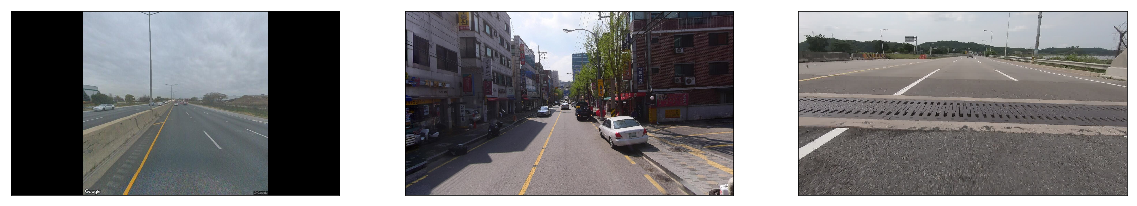

In [46]:
fig = plt.figure(figsize=(20,8))
for idx, image in enumerate(sample_images,1):
    ax = fig.add_subplot(1,len(sample_images),idx)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# \[ Tensorflow의 Session을 활용하여 로컬환경에서 Inference 하기 \]
---

![Imgur](https://imgur.com/S4NJOYT.png)


> **MaskLab 모델**은 (Retina**Mask** + deep**Lab**)을 합친 형태로 구성되어 있습니다. RetinaMask는 Instance Segmentation를 수행하고, DeepLab은 Semantic Segmentation을 수행합니다. MaskLab 모델은 One-Time Inference로 동시에 두가지 Task를 수행합니다.

## 1. 모델 불러오기
----

학습된 모델은 아래를 이용해 불러올 수 있습니다. 학습 시의 모델 구성과 추론 시의 모델 구성은 상이하기 때문에, 아래와 같이 학습된 모델의 Weight를 바탕으로 추론 모델을 재구성하는 방식으로 진행합니다.

In [47]:
from engine.layers import *
from engine.retinamasklab import load_masklab_inference_model_from_h5
from engine.config import ModelConfiguration

from engine.utils.visualize import show_graph

## 2. Serving을 위한 Inference Model 구성하기
----

In [10]:
# https://graphviz.readthedocs.io/en/stable/manual.html
from graphviz import Digraph

In [13]:
# # Sampling
image_path = random.choice(
    glob.glob("../hyundai/datasets/images/*.jpg"))

with open(image_path, 'rb') as f:
    contents = f.read()

### (1) JPG 디코딩 및 배치축 추가

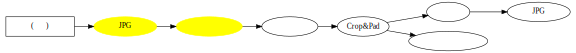

In [14]:
dot = Digraph(name='Serving Model Pipeline')
dot.attr(rankdir='LR', size='8,5')
dot.node('1', '이미지 파일(입력)', shape='box')
dot.node('2', 'JPG 디코딩', shape='ellipse',
         color='yellow',style='filled'); dot.edge('1','2')
dot.node('3', '배치축 추가', shape='ellipse',
         color='yellow',style='filled'); dot.edge('2','3')
dot.node('4.', '모델 처리', shape='ellipse'); dot.edge('3','4.')
dot.node('4', 'Crop&Pad', shape='ellipse'); dot.edge('4.','4')
dot.node('5', '시각화', shape='ellipse'); dot.edge('4','5')
dot.node('6', 'JPG 인코딩', shape='ellipse');dot.edge('5','6')
dot.node('7', '요약 정보 계산', shape='ellipse');dot.edge('4','7')
dot

In [18]:
from tensorflow.keras.layers import Input
from engine.layers import DecodeImageContent

In [19]:
inputs = Input(shape=(), dtype=tf.string)

decode = DecodeImageContent()
decoded_inputs = decode(inputs)

run = lambda x : K.get_session().run(x, 
                                     feed_dict={inputs: [contents]})    

0.04263782501220703


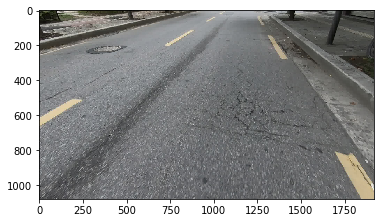

In [20]:
s = time.time()
result = run(decoded_inputs)
print(time.time() - s)
plt.imshow(result[0])
plt.show()

### (2) 모델 처리

모델 내 대부분 hyper-parameter는 Graph Building 단계에서 결정되지만, 아래와 같이 최종 출력 단에서의 몇 가지 Hyper Parameter은 조정할 수 있습니다. <br>

세부적인 성능 개선은 아래의 Hyper Parameter 조합으로 이루어 낼 수 있습니다.

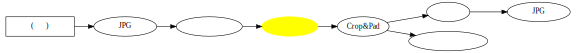

In [21]:
dot = Digraph(name='Serving Model Pipeline')
dot.attr(rankdir='LR', size='8,5')
dot.node('1', '이미지 파일(입력)', shape='box')
dot.node('2', 'JPG 디코딩', shape='ellipse'); dot.edge('1','2')
dot.node('3', '배치축 추가', shape='ellipse'); dot.edge('2','3')
dot.node('4.', '모델 처리', shape='ellipse',
         color='yellow',style='filled'); dot.edge('3','4.')
dot.node('4', 'Crop&Pad', shape='ellipse'); dot.edge('4.','4')
dot.node('5', '시각화', shape='ellipse'); dot.edge('4','5')
dot.node('6', 'JPG 인코딩', shape='ellipse');dot.edge('5','6')
dot.node('7', '요약 정보 계산', shape='ellipse');dot.edge('4','7')
dot

In [22]:
from engine.retinamasklab import load_masklab_inference_model_from_h5

In [25]:
config.postprocess.resolution = (540, 960)  # 학습 시 사용하였던 기준 Resolution
config.postprocess.min_confidence = 0.3     # 물체라 인식하는 최소 Confidence
config.postprocess.nms_iou_threshold = 0.35 # 동일 사물의 겹치는 비율(Intersection-Over-Union) 값. 이를 넘으면 동일한 사물로 파악
config.postprocess.post_iou_threshold = 0.6 # 다른 사물의 겹치는 비율(Intersection-Over-Union) 값. 이를 넘으면 같은 사물을 오분류한 것으로 파악

config.postprocess.smoothing_kernel_sizes = (11, 11, 3) # 커질수록 경계가 부드럽게 이어지지만, 세밀한 특성을 놓침 (Other Road, My Road, Crack)
config.postprocess.smoothing_weights = (1., 1., 3.) # Confidence 값을 증폭 혹은 감쇄 (Other Road, My Road, Crack)

K.clear_session()
# 현재에는 seresnet34 based model로 구성되어 있습니다. 
MODEL_PATH = os.path.join(ARCHIEVE_DIR, 'weights.h5')

model = load_masklab_inference_model_from_h5(MODEL_PATH, config, 
                                             serving=True)

weight을 .h5로부터 불러오는 중...
완료....(소요시간  :20.791s)
backbone Network를 재구성하는 중...
완료....(소요시간  :0.037s)
Detection Network를 재구성하는 중...
완료....(소요시간  :0.007s)
Instance Segmentation Network를 재구성하는 중...
완료....(소요시간  :0.007s)
Semantic Segmentation Network를 재구성하는 중...
완료....(소요시간  :0.003s)
각 Backbone Network와 Sub Network를 잇는 중...
완료....(소요시간  :7.208s)
DownSampling 적용 중...
완료....(소요시간  :8.560s)
후처리 코드 적용 중...
완료....(소요시간  :4.234s)
Upsampling 적용 중...
완료....(소요시간  :0.308s)


In [26]:
images, det_outs, ins_outs, seg_outs = model.predict(
    np.array([contents]))

### (3) Crop and Pad



In [27]:
dot = Digraph(name='Serving Model Pipeline')
dot.attr(rankdir='LR', size='8,5')
dot.node('1', '이미지 파일(입력)', shape='box')
dot.node('2', 'JPG 디코딩', shape='ellipse'); dot.edge('1','2')
dot.node('3', '배치축 추가', shape='ellipse'); dot.edge('2','3')
dot.node('4.', '모델 처리', shape='ellipse'); dot.edge('3','4.')
dot.node('4', 'Crop&Pad', shape='ellipse',
         color='yellow',style='filled'); dot.edge('4.','4')
dot.node('5', '시각화', shape='octagon'); dot.edge('4','5')
dot.node('5.', 'semantic 시각화', shape='ellipse'); dot.edge('5','5.')
dot.node('5*', 'Instance 시각화', shape='ellipse'); dot.edge('5.','5*')
dot.node('6', 'JPG 인코딩', shape='ellipse');dot.edge('5*','6')

dot.node('7', '요약 정보', shape='octagon');dot.edge('4','7')
dot.node('7', 'my road 포함 유무', shape='octagon');dot.edge('4','7')

In [28]:
from engine.layers import CropAndPadMask
from tensorflow.keras.models import Model

In [29]:
crop_and_padded_masks = CropAndPadMask()(model.outputs)

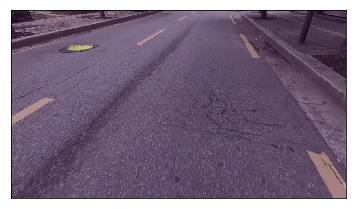

In [30]:
results = (
    Model(model.input, crop_and_padded_masks)
    .predict(np.array([contents])))
for result in results[0]:
    plt.imshow(images[0])
    plt.imshow(result,alpha=0.3)
    plt.xticks([]); plt.yticks([])
    plt.show()

### (4) Semantic 시각화

In [31]:
from engine.layers import DrawSegmentation

In [32]:
semantic_colors = [
    [ 64,   0, 128],
    [128,  96,   0],
    [128, 192,   0]]

In [33]:
vis_semantic = DrawSegmentation(semantic_colors)([images, seg_outs])

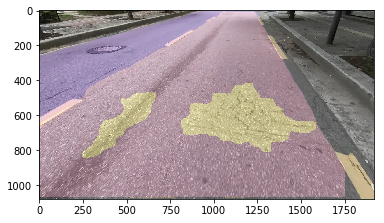

In [34]:
results = (
    Model(model.input, vis_semantic)
    .predict(np.array([contents])))

plt.imshow(results[0])
plt.show()

### (5) Instance 시각화

In [35]:
from engine.layers import DrawInstance

In [36]:
instance_colors = [
    [192,  32, 128],
    [160,  96,   0],
    [ 96,   0, 128],
    [ 32,  96, 192],
    [ 96,  32, 128]]

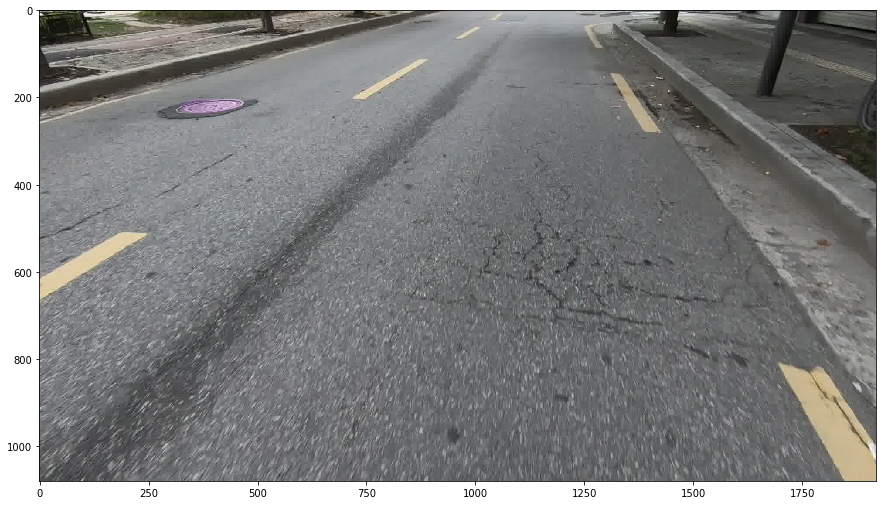

In [37]:
vis_instance = DrawInstance(instance_colors)(
    [images, det_outs, crop_and_padded_masks])

results = (
    Model(model.input, vis_instance)
    .predict(np.array([contents])))

plt.figure(figsize=(15,10))
plt.imshow(results[0])
plt.show()

### (6) Box 시각화

In [38]:
from engine.layers import DrawBoxes

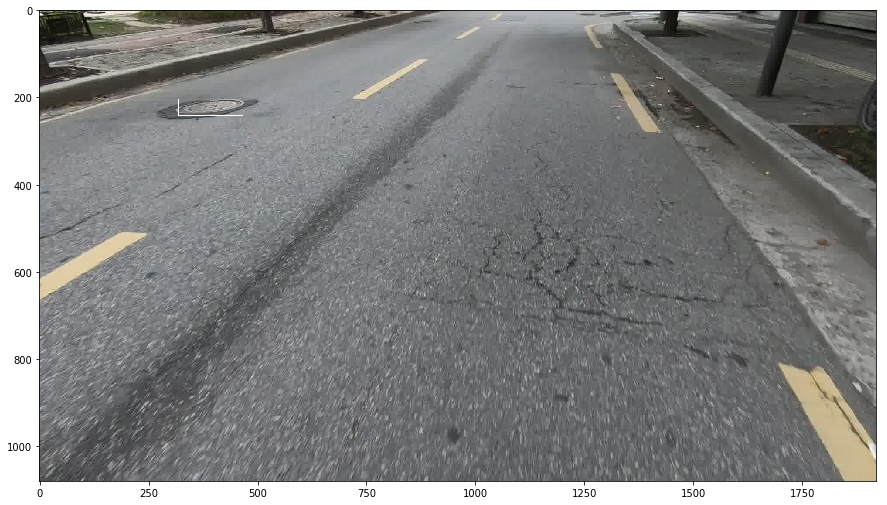

In [39]:
vis_boxes = DrawBoxes()([images, det_outs])

results = (
    Model(model.input, vis_boxes)
    .predict(np.array([contents])))

plt.figure(figsize=(15,10))
plt.imshow(results[0])
plt.show()

### (7) 시각화 모두 적용하기

In [40]:
vis_boxes = DrawBoxes()([images, det_outs])
vis_instance = DrawInstance(instance_colors)(
    [vis_boxes, det_outs, crop_and_padded_masks])
vis_semantic = DrawSegmentation(semantic_colors)(
    [vis_instance, seg_outs])

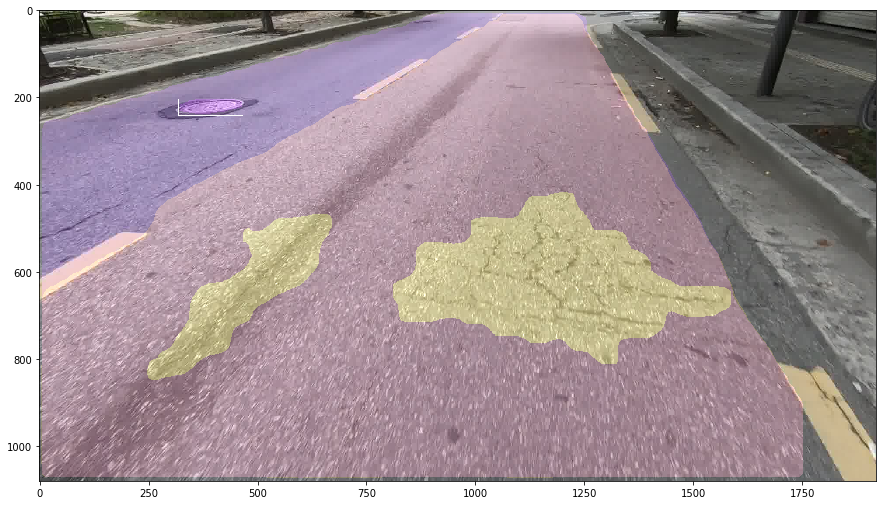

In [41]:
results = (
    Model(model.input, vis_semantic)
    .predict(np.array([contents])))

plt.figure(figsize=(15,10))
plt.imshow(results[0])
plt.show()